### Exploratory Notebook Trying to Get MHD Orzang Tang looking nice... 


In [1]:

import os

#using GPU, comment out if on CPU?
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
import jax
jax.config.update("jax_disable_jit", False)

jax.config.update("jax_debug_nans", True)
print(jax.lib.xla_bridge.get_backend().platform_version)  # sanity: shows CUDA/cuDNN


/tmp/ipykernel_11270/1581227358.py:10: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print(jax.lib.xla_bridge.get_backend().platform_version)  # sanity: shows CUDA/cuDNN


PJRT C API
cuda 12030


In [2]:
#load athena ICs (not used in this version)
import h5py
import jax.numpy as jnp


In [3]:
import diffhydro as dh


eq = dh.equationmanager_mhd.EquationManagerMHD()
eq.mesh_shape=[128,128,1]

In [4]:
def orszag_tang_2d(eq, embed_in_3d: bool = True):
    # use eq.mesh_shape and optional eq.box_size
    import jax.numpy as jnp

    nx, ny = eq.mesh_shape[0], eq.mesh_shape[1]
    nz = eq.mesh_shape[2] if (len(eq.mesh_shape) > 2) else 1
    box_size = getattr(eq, "box_size", (2.0 * jnp.pi, 2.0 * jnp.pi, 1.0))
    Lx, Ly = float(box_size[0]), float(box_size[1])

    x = (jnp.arange(nx) + 0.5) * (Lx / nx)
    y = (jnp.arange(ny) + 0.5) * (Ly / ny)
    X, Y = jnp.meshgrid(x, y, indexing="ij")

    rho0 = 25.0 / (36.0 * jnp.pi)
    p0   =  5.0 / (12.0 * jnp.pi)

    rho = jnp.ones((nx, ny)) * rho0
    u   = -jnp.sin(Y); v = jnp.sin(X); w = jnp.zeros_like(u)
    Bx  = -jnp.sin(1.0*Y); By = 0.5 * jnp.sin(2.0 * X); Bz = jnp.zeros_like(u)
    p   = jnp.ones_like(u) * p0

    W2 = jnp.stack([rho, u, v, w, Bx, By, Bz, p], axis=0)  # (8, nx, ny)

    W = jnp.repeat(W2[..., jnp.newaxis], nz, axis=-1) if embed_in_3d else W2
    U = eq.get_conservatives_from_primitives(W)

    #GLM, not tried
    if getattr(eq, "n_cons", U.shape[0]) == 9 and U.shape[0] == 8:
        psi = jnp.zeros_like(U[0])
        U = jnp.vstack([U, psi[jnp.newaxis, ...]])

    t_final = 0.5
    return U, t_final

In [5]:
gamma = 5 / 3

# spatial domain
box_size = 1.0
num_cells = 128

x = jnp.linspace(0, box_size, num_cells)
y = jnp.linspace(0, box_size, num_cells)
X, Y = jnp.meshgrid(x, y, indexing="ij")

# Initialize state
rho = jnp.ones_like(X) * gamma**2 / (4 * jnp.pi)
P = jnp.ones_like(X) * gamma / (4 * jnp.pi)

V_x = -jnp.sin(2 * jnp.pi * Y)
V_y = jnp.sin(2 * jnp.pi * X)
V_z = jnp.zeros_like(X)

B_0 = 1 / jnp.sqrt(4 * jnp.pi)
B_x = -B_0 * jnp.sin(2 * jnp.pi * Y)
B_y = B_0 * jnp.sin(4 * jnp.pi * X)
B_z = jnp.zeros_like(X)

initial_magnetic_field = jnp.stack([B_x, B_y, B_z], axis=0)


In [6]:
prim = jnp.stack([rho,V_x,V_y,V_z, B_x,B_y,B_z,P])

In [7]:
prim = prim[:,:,:,jnp.newaxis]

In [8]:
IC,_ = orszag_tang_2d(eq)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['gamma']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


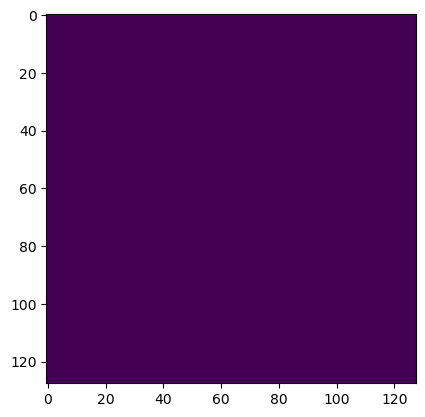

In [9]:
%pylab inline
imshow(prim[6])

In [10]:
from diffhydro.solver.riemann_solver import RiemannSolver

In [11]:
dh.LIMITER_DICT.keys()

dict_keys(['KOREN', 'MINMOD', 'SUPERBEE', 'VANALBADA', 'VANLEER', 'MC'])

In [12]:
#imshow(output_baseline[0][2])
#colorbar()

In [13]:
#dh.ConvectiveFlux?


using CT? True
using CT? True
using CT? True


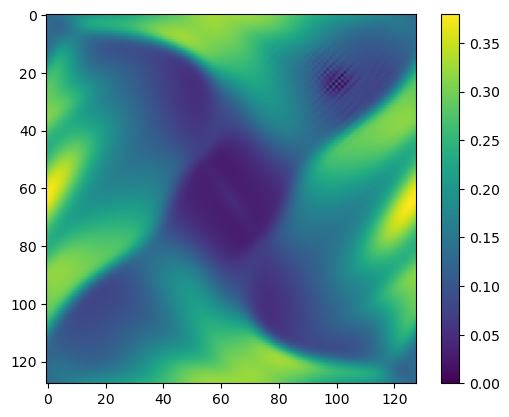

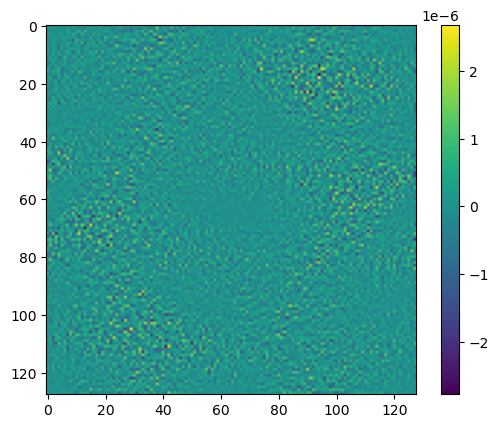

In [16]:
def divB(U):
    Bx, By, Bz = U[4], U[5], U[6]
    dx = 1
    return ((Bx - jnp.roll(Bx, 1, axis=0)) +
            (By - jnp.roll(By, 1, axis=1)) +
            (Bz - jnp.roll(Bz, 1, axis=2))) / dx

#trying a very diffusive setup and seeing what happens...

eq.gamma = 5/3

#not sure why CFL has to be so low...
eq.cfl= 0.1
#solver = dh.HLL_MHD(equation_manager=eq,signal_speed=None)
solver = dh.LaxFriedrichs_MHD(equation_manager=eq)  # or HLL_MHD

for key in ['']:# VANLEER']:#,'SUPERBEE','MC','KOREN', 'MINMOD','VANALBADA']:
    print(key)
    cf = dh.ConvectiveFlux(eq,solver,dh.WENO1(),positivity=True)
    
    #dh.MUSCL3(limiter=key)
    
    hydro_baseline = dh.hydro_ct(n_super_step=2500, 
                                 fluxes=[cf],
                                 forces=[],
                                 use_mol=True,
                                 use_ct=True, 
                                 integrator="RK2") 
    
    params = {}
    cons = eq.get_conservatives_from_primitives(prim)
   #try:
    output_baseline = hydro_baseline.evolve(cons,params)
    
    
    field_out = output_baseline[0]
    field_out_prim = eq.get_primitives_from_conservatives(field_out)
    imshow(field_out_prim[-1][:,:,0])
    plt.colorbar()
    plt.show()
    imshow(divB(field_out)) # ,vmin=-0.1,vmax=0.1)
    colorbar()
    show()
    
    #except:
    #    print("error!")


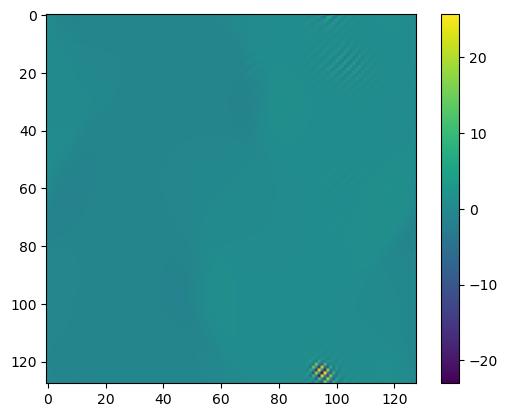

In [18]:
imshow(field_out[-4])
colorbar()

In [ ]:
#messing around with other numerics...

In [ ]:

import jax.numpy as jnp
from jax import Array


class Rusanov_MHD(RiemannSolver):
    """
    Local Lax–Friedrichs (Rusanov) solver for ideal MHD:
      F = 0.5*(F_L + F_R) - 0.5*alpha*(U_R - U_L)
    with alpha = max( |u_n| + c_fast ) on each face.
    """

    def __init__(self, equation_manager, signal_speed=None, **kwargs):
        super().__init__(equation_manager, signal_speed)

    def _solve_riemann_problem_xi_single_phase(
        self,
        primitives_L: Array, primitives_R: Array,
        conservatives_L: Array, conservatives_R: Array,
        axis: int, **kwargs
    ):
        # Physical fluxes from the eq manager (same pattern as HLL/HLLD)
        F_L = self.equation_manager.get_fluxes_xi(primitives_L, conservatives_L, axis)
        F_R = self.equation_manager.get_fluxes_xi(primitives_R, conservatives_R, axis)

        # Normal velocities (repo-managed indexing)
        uL = primitives_L[self.velocity_ids[axis]]
        uR = primitives_R[self.velocity_ids[axis]]

        # Fast magnetosonic speeds (EquationManagerMHD provides this)
        c_fL = self.equation_manager.get_fast_magnetosonic_speed(primitives_L, axis)
        c_fR = self.equation_manager.get_fast_magnetosonic_speed(primitives_R, axis)

        alpha = jnp.maximum(jnp.abs(uL) + c_fL, jnp.abs(uR) + c_fR)

        fluxes_xi = 0.5 * (F_L + F_R) - 0.5 * alpha * (conservatives_R - conservatives_L)
        return fluxes_xi, None, None

class Rusanov_MHD_StarCentral(RiemannSolver):
    """
    MHD Riemann solver whose central part is F(U_star) with
    U_star = arithmetic average of L/R, as in constrainedtransport.py,
    then adds Rusanov diffusion with alpha = max(|u_n| + c_fast).
    """

    def __init__(self, equation_manager, signal_speed=None, **kwargs):
        super().__init__(equation_manager, signal_speed)

    def _gather_xvars(self, primitives: Array, conservatives: Array, axis: int):
        rho = primitives[0]
        u   = primitives[self.velocity_ids[axis]]
        # pick a transverse velocity for 2D (assuming axes 0=x, 1=y)
        v   = primitives[self.velocity_ids[1 if axis == 0 else 0]]
        # magnetic components: Bn (= along axis) and Bt (= transverse)
        Bn  = primitives[self.magnetic_ids[axis]]
        Bt  = primitives[self.magnetic_ids[1 if axis == 0 else 0]]
        E   = conservatives[self.energy_id]
        return rho, u, v, Bn, Bt, E

    def _pressure_total_from_star(self, gamma, rho_s, momx_s, momy_s, Bn_s, Bt_s, E_s):
        kin = 0.5 * ((momx_s**2 + momy_s**2) / jnp.maximum(rho_s, 1e-30))
        B2  = Bn_s**2 + Bt_s**2
        # total pressure = gas + magnetic
        # gas = (gamma-1) * (E - kin - 0.5*B^2); add + 0.5*B^2 back to get total
        Ptot = (gamma - 1.0) * (E_s - kin - 0.5 * B2) + 0.5 * B2
        return Ptot

    def _solve_riemann_problem_xi_single_phase(
        self,
        primitives_L: Array, primitives_R: Array,
        conservatives_L: Array, conservatives_R: Array,
        axis: int, **kwargs
    ):
        gm = self.equation_manager
        gamma = gm.gamma

        # Extract per-side variables in the swept direction
        rhoL, uL, vL, BnL, BtL, EL = self._gather_xvars(primitives_L, conservatives_L, axis)
        rhoR, uR, vR, BnR, BtR, ER = self._gather_xvars(primitives_R, conservatives_R, axis)

        # Build star (averaged) states — EXACTLY like constrainedtransport.py
        rho_s  = 0.5 * (rhoL + rhoR)
        momx_s = 0.5 * (rhoL * uL + rhoR * uR)
        momy_s = 0.5 * (rhoL * vL + rhoR * vR)
        E_s    = 0.5 * (EL + ER)
        Bn_s   = 0.5 * (BnL + BnR)
        Bt_s   = 0.5 * (BtL + BtR)

        Ptot_s = self._pressure_total_from_star(gamma, rho_s, momx_s, momy_s, Bn_s, Bt_s, E_s)

        # Central flux F(U_star) for the 5 components your script advances along x:
        # mass, momx, momy, energy, and transverse B (Bt).
        # (The normal magnetic component Bn has zero physical flux in ideal MHD along n.)
        F_mass   = momx_s
        F_momx   = (momx_s**2) / jnp.maximum(rho_s, 1e-30) + Ptot_s - Bn_s * Bn_s
        F_momy   = (momx_s * momy_s) / jnp.maximum(rho_s, 1e-30) - Bn_s * Bt_s
        F_energy = (E_s + Ptot_s) * (momx_s / jnp.maximum(rho_s, 1e-30)) \
                   - Bn_s * (Bn_s * (momx_s / jnp.maximum(rho_s, 1e-30)) \
                             + Bt_s * (momy_s / jnp.maximum(rho_s, 1e-30)))
        F_Bt     = (Bt_s * (momx_s / jnp.maximum(rho_s, 1e-30)) \
                    - Bn_s * (momy_s / jnp.maximum(rho_s, 1e-30)))

        # Build a full flux vector shaped like conservatives, then fill components
        fluxes_xi = jnp.zeros_like(conservatives_L)
        fluxes_xi = fluxes_xi.at[self.mass_id].set(F_mass)
        fluxes_xi = fluxes_xi.at[self.momentum_ids[axis]].set(F_momx)
        fluxes_xi = fluxes_xi.at[self.momentum_ids[1 if axis == 0 else 0]].set(F_momy)
        fluxes_xi = fluxes_xi.at[self.energy_id].set(F_energy)
        fluxes_xi = fluxes_xi.at[self.magnetic_ids[1 if axis == 0 else 0]].set(F_Bt)
        # (Leave flux for the normal magnetic component as 0.)

        # Rusanov diffusion with alpha = max(|u| + c_fast)
        cfastL = gm.get_fast_magnetosonic_speed(primitives_L, axis)
        cfastR = gm.get_fast_magnetosonic_speed(primitives_R, axis)
        alpha  = jnp.maximum(jnp.abs(uL) + cfastL, jnp.abs(uR) + cfastR)

        jump = (conservatives_R - conservatives_L)
        fluxes_xi = fluxes_xi - 0.5 * alpha * jump

        return fluxes_xi, None, None
    
class BJ_PLM:
    """
    Piecewise-linear reconstruction that replicates constrainedtransport.py:
      - central difference slope d_i = 0.5 * (q_{i+1} - q_{i-1})
      - Barth–Jespersen style slope clipping along the sweep axis (no overshoot)
      - face states: q_{i+1/2}^L = q_i   + 0.5 * d_i
                     q_{i+1/2}^R = q_{i+1} - 0.5 * d_{i+1}
    No explicit dx is needed since the dx cancels between gradient and ±dx/2 extrapolation.
    """

    def __init__(self, eps: float = 1e-12):
        self.eps = eps

    def _central_slope(self, q: Array, axis: int) -> Array:
        # centered difference (q_{i+1} - q_{i-1}) / 2
        qm1 = jnp.roll(q, +1, axis=axis)
        qp1 = jnp.roll(q, -1, axis=axis)
        return 0.5 * (qp1 - qm1)

    def _bj_clip_axis(self, q: Array, d: Array, axis: int) -> Array:
        """
        Barth–Jespersen-style limiter *along the sweep axis only*,
        mirroring constrainedtransport.py’s two clipping passes:
            d *= max(0, min(1, (q_i - q_{i-1}) / d ))
            d *= max(0, min(1, (-(q_i - q_{i+1})) / d ))
        with robust eps guards.
        """
        qi   = q
        qim1 = jnp.roll(q, +1, axis=axis)
        qip1 = jnp.roll(q, -1, axis=axis)

        # First clip: left neighbor
        numL = (qi - qim1)
        den  = d + self.eps * (d == 0)
        facL = jnp.maximum(0.0, jnp.minimum(1.0, numL / den))

        # Second clip: right neighbor
        numR = -(qi - qip1)  # = (q_{i+1} - q_i)
        facR = jnp.maximum(0.0, jnp.minimum(1.0, numR / (d + self.eps * (d == 0))))

        return d * facL * facR

    def reconstruct_xi(self, buffer: Array, axis: int, j: int) -> Array:
        # buffer is [nvar, ...]; run per-component with identical stencil
        def per_comp(q):
            d  = self._central_slope(q, axis-1)
            dl = self._bj_clip_axis(q, d, axis-1)
            qL = q + 0.5 * dl  # at i+1/2 from cell i
            # right state uses slope from i+1
            qR = jnp.roll(q, -1, axis=axis-1) - 0.5 * jnp.roll(dl, -1, axis=axis-1)
            return jnp.where(j == 0, qL, qR)
        return jnp.stack([per_comp(buffer[k]) for k in range(buffer.shape[0])])

In [ ]:
import jax.numpy as jnp
from jax import Array

class Rusanov_MHD_StarCentral(RiemannSolver):
    """
    Central part uses F(U_star) with U_star the arithmetic average of L/R states,
    then adds LLF/Rusanov diffusion with alpha = max(|u_n| + c_fast).
    Indices (rho, velocities, B, E) come from the equation manager.
    """

    def __init__(self, equation_manager, signal_speed=None, **kwargs):
        super().__init__(equation_manager, signal_speed)

    def _gather_axis_slices(self, W: Array, U: Array, axis: int):
        """Pick out n (normal) vs t (transverse) components based on axis, using manager ids."""
        rho_i   = self.mass_ids
        E_i     = self.energy_ids
        u_i, v_i, w_i = self.velocity_ids   # set by base class from manager
        b1_i, b2_i, b3_i = self.equation_manager.mag_ids  # from manager

        rho = W[rho_i]
        E   = U[E_i]
        vn  = W[self.velocity_ids[axis]]                 # normal velocity component
        # pick one transverse component (2D case): use the "next" axis cyclically
        t_axis = 1 if axis == 0 else 0
        if W.shape[0] >= 7:  # MHD prims include 3 velocities + 3 B + p
            vt  = W[self.velocity_ids[t_axis]]
            # normal/transverse B:
            Bn  = W[self.equation_manager.mag_ids[axis]]
            Bt  = W[self.equation_manager.mag_ids[t_axis]]
        else:
            # should not happen for MHD, but keep guards
            vt = jnp.zeros_like(vn); Bn = 0.0; Bt = 0.0

        return rho, vn, vt, Bn, Bt, E

    def _ptot_from_star(self, gamma, rho_s, momn_s, momt_s, Bn_s, Bt_s, E_s, eps):
        inv_rho = 1.0 / jnp.maximum(rho_s, eps)
        ke  = 0.5 * (momn_s*momn_s + momt_s*momt_s) * inv_rho
        B2  = Bn_s*Bn_s + Bt_s*Bt_s
        p_g = (gamma - 1.0) * (E_s - ke - 0.5 * B2)
        p_g = jnp.maximum(p_g, eps)
        return p_g + 0.5 * B2  # total pressure

    def _solve_riemann_problem_xi_single_phase(
        self,
        primitives_L: Array, primitives_R: Array,
        conservatives_L: Array, conservatives_R: Array,
        axis: int, **kwargs
    ):
        gm   = self.equation_manager
        eps  = getattr(gm, "eps", 1e-20)
        gamma = gm.gamma

        # Gather per-side variables along swept axis using manager-provided ids
        rhoL, vnL, vtL, BnL, BtL, EL = self._gather_axis_slices(primitives_L, conservatives_L, axis)
        rhoR, vnR, vtR, BnR, BtR, ER = self._gather_axis_slices(primitives_R, conservatives_R, axis)

        # Star (arithmetic-average) state — matches constrainedtransport.py idea
        rho_s  = 0.5 * (rhoL + rhoR)
        momn_s = 0.5 * (rhoL * vnL + rhoR * vnR)
        momt_s = 0.5 * (rhoL * vtL + rhoR * vtR)
        E_s    = 0.5 * (EL + ER)
        Bn_s   = 0.5 * (BnL + BnR)
        Bt_s   = 0.5 * (BtL + BtR)

        # Total pressure at star
        ptot_s = self._ptot_from_star(gamma, rho_s, momn_s, momt_s, Bn_s, Bt_s, E_s, eps)
        inv_rho_s = 1.0 / jnp.maximum(rho_s, eps)
        vn_s = momn_s * inv_rho_s
        vt_s = momt_s * inv_rho_s

        # Build a flux vector F(U_star) using the standard MHD form (manager’s layout):
        F = jnp.zeros_like(conservatives_L)
        # mass
        F = F.at[self.mass_ids].set(momn_s)
        # momentum (normal and one transverse filled; the other transverse stays as in central 0)
        F = F.at[self.velocity_ids[axis]].set(momn_s * vn_s + ptot_s - Bn_s * Bn_s)
        F = F.at[self.velocity_ids[1 if axis == 0 else 0]].set(momn_s * vt_s - Bn_s * Bt_s)
        # magnetic (only transverse component changes in n-flux; normal B has zero n-flux)
        F = F.at[gm.mag_ids[1 if axis == 0 else 0]].set(vn_s * Bt_s - Bn_s * vt_s)
        # energy
        vdotB_s = vn_s * Bn_s + vt_s * Bt_s
        F_E = (E_s + ptot_s) * vn_s - vdotB_s * Bn_s
        F = F.at[self.energy_ids].set(F_E)

        # Rusanov diffusion with alpha = max(|vn| + c_fast) (from manager)
        cfastL = gm.get_fast_magnetosonic_speed(primitives_L, axis)
        cfastR = gm.get_fast_magnetosonic_speed(primitives_R, axis)
        alpha  = jnp.maximum(jnp.abs(vnL) + cfastL, jnp.abs(vnR) + cfastR)

        fluxes_xi = F - 0.5 * alpha * (conservatives_R - conservatives_L)
        return fluxes_xi, None, None
